In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error

import os
import sys

import data_processing as dp

sys.path.append(os.path.abspath("../.."))



data = pd.read_csv('../spx_vhs.csv')

data = data.drop(columns=['high','low','close','time','vel_15'])

print(data.columns)

X, y = dp.make_prll_trgt(data=data.values, index=6,offset=60)

X = np.delete(X, 6, axis=1)

use_lstm = True

scaler = StandardScaler()
X = scaler.fit_transform(X)


if(use_lstm):
    X, y = dp.reformat_to_lstm(X, y, 15)

tod_mask = (X[:, 0] >= 600) & (X[:, 0] <= 900)

#X = X[tod_mask]
#y = y[tod_mask]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

opt = tf.keras.optimizers.Adam(learning_rate=0.025)
opt1 = tf.keras.optimizers.SGD(learning_rate=0.01)

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(4, activation='tanh', recurrent_dropout=0.0, return_sequences=True),
        tf.keras.layers.LSTM(4, activation='tanh', recurrent_dropout=0.0),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(64),
		#tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('gelu'),
        tf.keras.layers.Dropout(0.1),
        #tf.keras.layers.Dense(8, activation='relu'),       
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for regression
    ])
    
    rmse='root_mean_squared_error'

    model.compile(optimizer=opt1, loss='mse', metrics=['mae','R2Score',rmse])
    return model

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_R2Score', patience=15, mode='max', restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=8, 
    min_lr=1e-7
)

In [ ]:
epochs = 50

model = build_model()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_split=0.2, verbose=1, shuffle=False, callbacks=[early_stopping,reduce_lr])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

In [ ]:
print(np.mean(y<-5) + np.mean(y>5))

In [3]:
import numpy as np
import tensorflow as tf

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error

import os
import sys

import data_processing as dp

sys.path.append(os.path.abspath("../.."))



data = pd.read_csv('../spx_vhs.csv')

data = data.drop(columns=['high','low','close','time','vel_15'])

print(data.columns)

X, y = dp.make_prll_trgt(data=data.values, index=5,offset=1)

print(y.max(), y.min())

#X = np.delete(X, 6, axis=1)

use_lstm = True

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

Index(['volume', 'ToD', 'DoW', 'v_60_.08', 'h_60_.08', 's_60_.08', 'vel_60'], dtype='object')
100.0 0.0


In [4]:
import numpy as np
import tensorflow as tf

def make_day_dataset(X,
                     y,
                     time_idx=1,
                     min_time=570,
                     max_time=900,
                     to_lstm=False,
                     include_days=None):
    """
    Build a tf.data.Dataset that yields one day's windowed slice at a time.

    Args:
      X: np.ndarray, shape (N, F)     — feature matrix
      y: np.ndarray, shape (N,)       — parallel label array
      time_idx: int                   — index of looping time feature (0–1200)
      min_time, max_time: int         — inclusive window bounds
      to_lstm: bool                   — if True, output has leading batch dim
      include_days: list/np.ndarray   — which day IDs to include

    Returns:
      tf.data.Dataset yielding (x_batch, y_batch):
        if to_lstm=False:
          x_batch: (seq_len, F),   y_batch: (seq_len,)
        if to_lstm=True:
          x_batch: (1, seq_len, F), y_batch: (1, seq_len)
    """
    # infer day IDs by wrap‑around of the time feature
    times  = X[:, time_idx]
    day_id = np.concatenate([[0], np.cumsum(times[1:] < times[:-1])])

    # filter rows into your time window
    mask   = (times >= min_time) & (times <= max_time)
    X_f    = X[mask]
    y_f    = y[mask]
    days_f = day_id[mask]

    # restrict to a subset of days if requested
    if include_days is not None:
        keep   = np.isin(days_f, include_days)
        X_f    = X_f[keep]
        y_f    = y_f[keep]
        days_f = days_f[keep]

    # generator: one day's slice per iteration
    def gen():
        for d in np.unique(days_f):
            x_batch = X_f[days_f == d].astype(np.float32)
            y_batch = y_f[days_f == d].astype(np.float32)
            if to_lstm:
                x_batch = np.expand_dims(x_batch, 0)  # (1, seq_len, F)
                y_batch = np.expand_dims(y_batch, 0)  # (1, seq_len)
            yield x_batch, y_batch

    # declare the output shapes
    n_feats = X.shape[1]
    if to_lstm:
        spec = (
            tf.TensorSpec(shape=(1, None, n_feats), dtype=tf.float32),
            tf.TensorSpec(shape=(1, None)       , dtype=tf.float32),
        )
    else:
        spec = (
            tf.TensorSpec(shape=(None, n_feats), dtype=tf.float32),
            tf.TensorSpec(shape=(None,)        , dtype=tf.float32),
        )

    return tf.data.Dataset.from_generator(gen, output_signature=spec)


# ─── prepare & split days ───────────────────────────────────────────
# X: (N, F), y: (N,)

# 1) infer day IDs
times  = X[:, 1]
day_id = np.concatenate([[0], np.cumsum(times[1:] < times[:-1])])

# 2) find days with any data in [570, 900]
filtered_days = np.unique(day_id[(times >= 570) & (times <= 900)])

# 3) shuffle & 80/20 split
np.random.shuffle(filtered_days)
split       = int(len(filtered_days) * 0.8)
train_days  = filtered_days[:split]
test_days   = filtered_days[split:]

# ─── build tf.data.Datasets ────────────────────────────────────────
ds_train = (
    make_day_dataset(X, y,
                     time_idx=1,
                     min_time=570,
                     max_time=900,
                     to_lstm=True,
                     include_days=train_days)
    .repeat()
    .shuffle(buffer_size=max(len(train_days), 1))
    .prefetch(tf.data.AUTOTUNE)
)

ds_test = (
    make_day_dataset(X, y,
                     time_idx=1,
                     min_time=570,
                     max_time=900,
                     to_lstm=True,
                     include_days=test_days)
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

# ─── define & compile model ────────────────────────────────────────
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, X.shape[1])),
    tf.keras.layers.Masking(),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# ─── fit with validation ────────────────────────────────────────────
history = model.fit(
    ds_train,
    epochs=20,
    steps_per_epoch=len(train_days),
    validation_data=ds_test,
    validation_steps=len(test_days),
    verbose=1
)


Epoch 1/20


I0000 00:00:1745257079.292798   34831 cuda_dnn.cc:529] Loaded cuDNN version 90300


242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 4163.3486 - mae: 50.7590 - val_loss: 4009.7271 - val_mae: 49.9337
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3785.1641 - mae: 48.2359 - val_loss: 3522.5225 - val_mae: 47.2143
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3241.7227 - mae: 45.0520 - val_loss: 3108.4443 - val_mae: 45.0458
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2869.3281 - mae: 43.0434 - val_loss: 2746.9597 - val_mae: 43.2164
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2562.8196 - mae: 41.7573 - val_loss: 2445.2063 - val_mae: 41.7111
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2299.7266 - mae: 40.3981 - val_loss: 2221.7407 - val_mae: 40.5888
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2087.2322 - mae: 39.3988 - val_loss: 2035.5756 - val_mae: 39.6476
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1961.6403 - mae: 39.1285 - val_loss: 1907.9573 - val_mae: 38.

KeyboardInterrupt: 

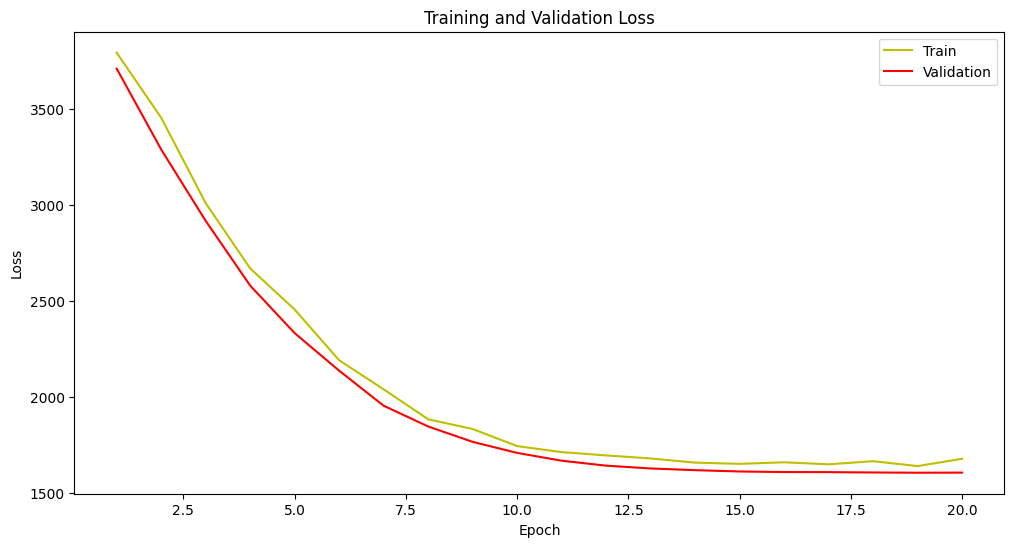

NameError: name 'X_test' is not defined

In [3]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY

'''plt.plot(epochs, history.history['R2Score'], 'y', label='Training R2')
plt.plot(epochs, history.history['val_R2Score'], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()'''


#predicting the test set results
y_pred = model.predict(X_test) 
#y_pred = y_pred > 0.5 # Predictions to class indices
'''
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Direction Classification')
plt.show()
'''

plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()
#DIRECTIONAL ACCURACY #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  
tp, fp, tn, fn = 0, 0, 0, 0
tp5, fp5, tn5, fn5 = 0, 0, 0, 0
for i in range(len(y_pred)):
    if(y_pred[i]>0):
        if(y_test[i]>0):
            tp+=1
        if(y_test[i]<0):
            fp+=1
        if(y_pred[i]>=50):
            if(y_test[i]>50):
                tp5+=1
            if(y_test[i]<50):
                fp5+=1
    if(y_pred[i]<0):
        if(y_test[i]<0):
            tn+=1
        if(y_test[i]>0):
            fn+=1
        if(y_pred[i]<=-5):
            if(y_test[i]<0):
                tn5+=1
            if(y_test[i]>0):
                fn5+=1
directionalAccuracy = ((tp+tn)/(tp+fp+tn+fn))*10000//1/100
print('Directional Accuracy:\t\t',directionalAccuracy)
directionalAccuracy5guess = ((tp5+tn5)/(tp5+fp5+tn5+fn5))*10000//1/100
print('Directional Accuracy >(+/-)5:\t',directionalAccuracy5guess)

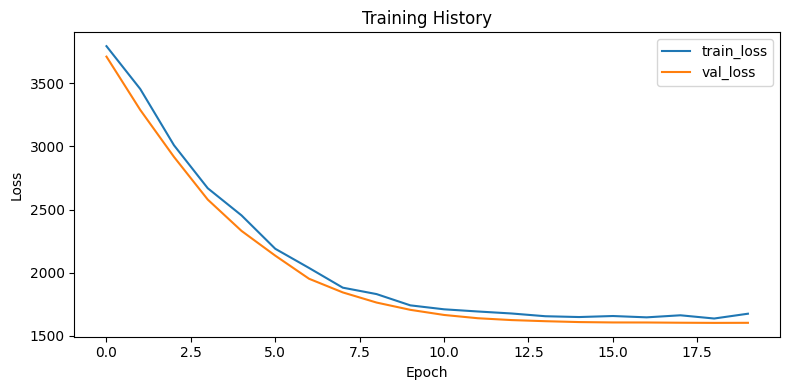

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


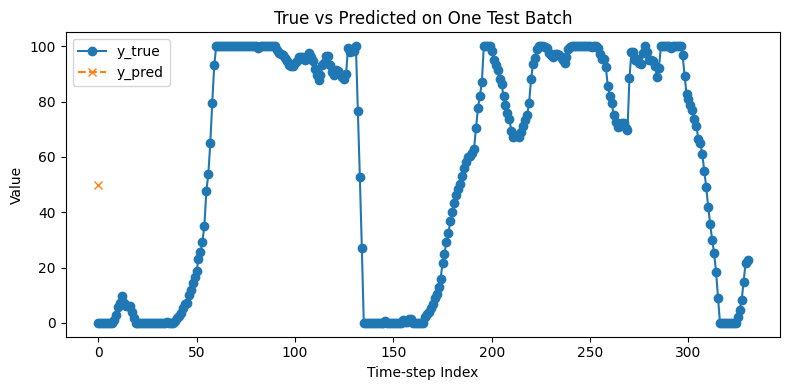

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf

# 1) Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],  label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Get one batch from the test-set and predict
x_test, y_test = next(iter(ds_test))     # x_test: (1, seq_len, feats), y_test: (1, seq_len)
y_pred = model.predict(x_test)           # shape (1, seq_len)

# flatten to 1D
y_true_flat = tf.reshape(y_test,   [-1]).numpy()
y_pred_flat = tf.reshape(y_pred,   [-1]).numpy()

plt.figure(figsize=(8,4))
plt.plot(y_true_flat, 'o-', label='y_true')
plt.plot(y_pred_flat, 'x--', label='y_pred')
plt.xlabel('Time-step Index')
plt.ylabel('Value')
plt.title('True vs Predicted on One Test Batch')
plt.legend()
plt.tight_layout()
plt.show()


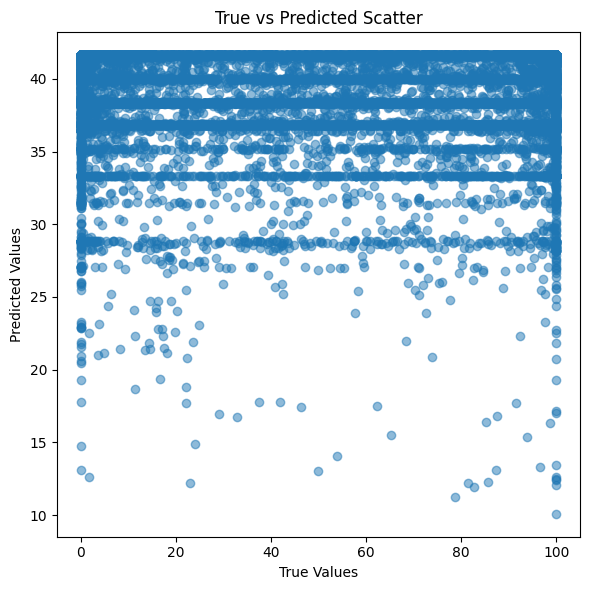

R² score: -0.1178


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Collect all true & predicted values at the sample‐level
y_trues = []
y_preds = []

# Assume ds_test is your repeated test‐day dataset,
# and test_days is the list/array of day IDs you split off.
for i, (x_batch, y_batch) in enumerate(ds_test):
    if i >= len(test_days):
        break

    # x_batch: shape (1, seq_len, n_feats)
    # y_batch: shape (1, seq_len)
    x_seq = x_batch.numpy()            # → (1, seq_len, n_feats)
    y_true_seq = y_batch.numpy().reshape(-1)  # → (seq_len,)
    
    seq_len = x_seq.shape[1]
    n_feats  = x_seq.shape[2]

    # reshape to (seq_len, 1, n_feats) so model.predict gives one output per sample
    x_samples = x_seq.reshape((seq_len, 1, n_feats))  # (seq_len, 1, n_feats)
    
    # Predict all samples in this day at once
    y_pred_seq = model.predict(x_samples, verbose=0).reshape(-1)  # → (seq_len,)

    y_trues.append(y_true_seq)
    y_preds.append(y_pred_seq)

# Concatenate across all days
y_trues = np.concatenate(y_trues)
y_preds = np.concatenate(y_preds)

# Scatter plot of true vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(y_trues, y_preds, alpha=0.5)
lims = [min(y_trues.min(), y_preds.min()),
        max(y_trues.max(), y_preds.max())]
#plt.plot(lims, lims, 'k--', linewidth=1)  # y = x reference
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Scatter')
plt.tight_layout()
plt.show()

# Optional: compute R²
print(f"R² score: {r2_score(y_trues, y_preds):.4f}")
